In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing, svm 
from sklearn import tree
from sklearn import neighbors

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error 

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import pearsonr


from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import XGBClassifier


from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, Conv1D, Activation, MaxPooling1D

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
#Reading the CSV

In [3]:
supernovae_df = pd.read_csv('./Documents/Supernovae.csv')

In [4]:
supernovae_df.rename(columns={'Column1':'optical_depth','Column2':'optical_depth_unc','Column3':'max_exp_vel','Column4':'max_exp_vel_unc','Column5':'emergent_flux','Column6':'total_mass','Column7':'mass_ni_56','Column8':'explosion_energy','Column9':'init_mass_dist','Column10':'init_rad_dist'},inplace=True)

In [5]:
supernovae_df

,optical_depth,optical_depth_unc,max_exp_vel,max_exp_vel_unc,emergent_flux,total_mass,mass_ni_56,explosion_energy,init_mass_dist,init_rad_dist
0,1.940628,0.179354,0.013531,0.000670,0.000003,0.75,0.15,0.75,hed8,hed8
1,2.071999,0.210287,0.012423,0.000615,0.000003,0.75,0.15,0.75,hed8,mwd
2,2.007982,0.198804,0.012744,0.000685,0.000003,0.75,0.15,0.75,hed8,N100
3,1.661535,0.189436,0.009935,0.000349,0.000003,0.75,0.15,0.75,hed8,w7dt
4,1.907672,0.178607,0.013343,0.000745,0.000003,0.75,0.15,2.00,hed8,hed8
...,...,...,...,...,...,...,...,...,...,...
507,2.651333,0.177355,0.011914,0.000536,0.000014,2.00,0.75,0.75,w7dt,w7dt
508,2.664973,0.149239,0.010600,0.000432,0.000014,2.00,0.75,2.00,w7dt,hed8
509,3.401588,0.213209,0.011660,0.000410,0.000014,2.00,0.75,2.00,w7dt,mwd
510,3.091225,0.191139,0.011329,0.000494,0.000014,2.00,0.75,2.00,w7dt,N100


In [6]:
#Checking for NaN values

supernovae_df.isnull().values.any()

False

In [7]:
#Checking whether the datatype of each column is proper or not

for i in range(10):
    print(type(supernovae_df.iloc[0][i]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>


# NOTES:

1. Generally, 75%+ accuracy scores have been considered as acceptable accuracies.
2. Only a few of the hyperparameter tunings have been presented in the notebook to keep it clean. The best possible tuned models have been displayed. 
3. All models were cross validated with train-test sets. 
4. The random states that were chosen for inclusion in this notebook are the ones that provided the best results achieved during fine-tuning the hyperparameters. 

# TASK 1 - relationship between observable parameters

A scatterplot can be used to determine if any of the observable parameters are correlated, and to see any other trends/classes that can be discerned through the distribution of observable parameters

<AxesSubplot:xlabel='optical_depth', ylabel='max_exp_vel'>

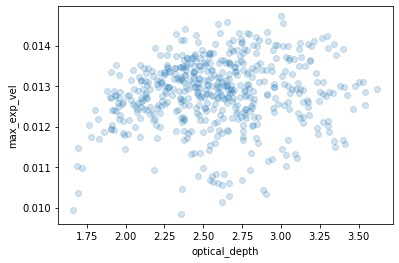

In [8]:
sns.regplot(x = "optical_depth", y="max_exp_vel", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='optical_depth', ylabel='emergent_flux'>

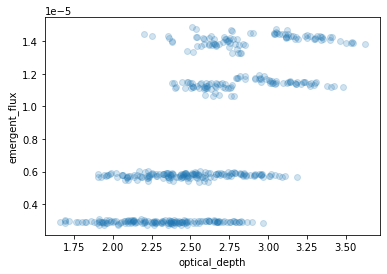

In [9]:
sns.regplot(x = "optical_depth", y="emergent_flux", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='emergent_flux', ylabel='max_exp_vel'>

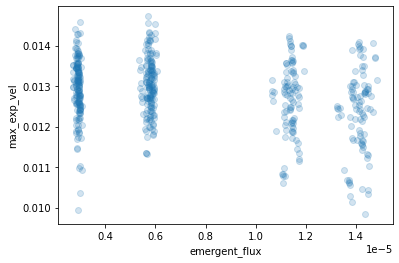

In [10]:
sns.regplot(x = "emergent_flux", y="max_exp_vel", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

# Inference: 

There are 4 disctinct classes of emergent flux. There aren't any district classes of max_exp_vel or optical_depth, which aren't correlated with each other either. This can be confirmed by checking the Pearson correlation coefficient for all of these. 

In [11]:
 #Confirming the same using Pearson's correlation coefficient
    
data1= supernovae_df['optical_depth']
data2= supernovae_df['max_exp_vel']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.139


In [12]:
data1= supernovae_df['emergent_flux']
data2= supernovae_df['max_exp_vel']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.256


In [13]:
data1= supernovae_df['optical_depth']
data2= supernovae_df['emergent_flux']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.632


Based on the ranges exhibited by emergent flux, we can create a categorical variable 'class of flux', which may be useful further on in categorical classification.

In [14]:


class_of_flux = []

for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['emergent_flux']<0.000004:
        class_of_flux.append(1)
    if  supernovae_df.iloc[i]['emergent_flux']<0.000008 and supernovae_df.iloc[i]['emergent_flux']>0.000004:
        class_of_flux.append(2)
    if  supernovae_df.iloc[i]['emergent_flux'] <0.000013 and supernovae_df.iloc[i]['emergent_flux']>0.000010:
        class_of_flux.append(3)
    if supernovae_df.iloc[i]['emergent_flux'] >0.000013:
        class_of_flux.append(4)
    
len(class_of_flux)

512

In [15]:
#Adding this to the dataframe

supernovae_df['class_of_flux'] = np.array(class_of_flux)

# Finding the uncertainities
Since the test data provided doesn't contain the uncertainities, and the uncertainity values are different in each row, it would be good to find a way to approximate the uncertainities for all optical_depth and max_exp_vel. 

In [16]:
#Relating the uncertainities to the values

In [17]:
#OPTICAL DEPTH UNC

supernovae_df['optical_depth_unc'].describe()

count    512.000000
mean       0.198927
std        0.021055
min        0.133992
25%        0.183659
50%        0.198672
75%        0.215768
max        0.239162
Name: optical_depth_unc, dtype: float64

In [18]:
mean_od_unc =  0.198927

In [19]:
#OD unc as a function of OD

d1 = supernovae_df['optical_depth']
d2 = supernovae_df['optical_depth_unc']

d3 = d2/d1

In [20]:
d3.describe()

count    512.000000
mean       0.078545
std        0.011796
min        0.047808
25%        0.069775
50%        0.078088
75%        0.086126
max        0.114326
dtype: float64

In [21]:
mean_od_unc_per = 0.078545

In [22]:
supernovae_df['optical_depth'].describe()

count    512.000000
mean       2.576275
std        0.391005
min        1.661535
25%        2.321794
50%        2.559251
75%        2.812090
max        3.621963
Name: optical_depth, dtype: float64

In [23]:
avg_od = 2.576275

In [24]:
avg_unc = avg_od * mean_od_unc_per

In [25]:
#The average uncertainity by taking the avg percentage error and the average od
avg_unc

0.202353519875

Since there isn't a huge different between the average uncertainity found using both methods, the percentage method seems preferable, so that the model doesn't get confused/overfit when all the features fed to it in the test data have the same uncertainity, as that would render the column useless. 

In [26]:
#MAX EXP VEL

d4 = supernovae_df['max_exp_vel']
d5 = supernovae_df['max_exp_vel_unc']

d6 = d5/d4

In [27]:
d6.describe()

count    512.000000
mean       0.039927
std        0.005138
min        0.026519
25%        0.036309
50%        0.039165
75%        0.042926
max        0.063529
dtype: float64

In [28]:
mean_mev_unc_per = 0.039927

PLEASE NOTE THAT HERE THE PERCENTAGES ARE LEFT AS RATIOS RATHER THAN MULTPLIYING THEM BY HUNDERED. Here, 0.0399 means 3.9%, not 0.0399%

# TASK 2 - Analysis of physical parameters

Initially, scatterplots can be plotted between all physical and observable parameters just to view any possible correlation and other trends that might point out existing classes

## Ni-56 mass

In [29]:
# Emergent flux vs ni-56 mass

<AxesSubplot:xlabel='emergent_flux', ylabel='mass_ni_56'>

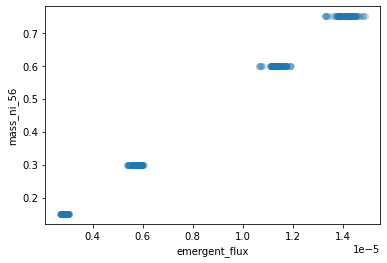

In [30]:
sns.regplot(x = "emergent_flux", y="mass_ni_56", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

We can see that there are some clear cut ranges for emergent flux and mass_ni_56, proving that both are highly correlated. 

In [31]:
#Pearson's correlation coefficient for mass_ni_56 and emergent flux

In [32]:
data1= supernovae_df['emergent_flux']
data2= supernovae_df['mass_ni_56']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.999


From Pearson's correlation coefficient we can see that they are highly correlated. 

In [33]:
supernovae_df.mass_ni_56.unique()

array([0.15, 0.3 , 0.6 , 0.75])

We see here that there are only 4 values of mass_ni_56, proving that we can group them into classes

In [34]:
class_of_ni = []
#So there are 4 classes of mass of nickel: <0.2, 0.2-0.4, 0.5-0.6. >0.7
for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['mass_ni_56']<=0.2:
        class_of_ni.append(1)
    if supernovae_df.iloc[i]['mass_ni_56']>0.2 and supernovae_df.iloc[i]['mass_ni_56']<=0.4:
        class_of_ni.append(2)
    if supernovae_df.iloc[i]['mass_ni_56']>0.5 and supernovae_df.iloc[i]['mass_ni_56']<=0.6:
        class_of_ni.append(3)
    if supernovae_df.iloc[i]['mass_ni_56']>0.7:
        class_of_ni.append(4)

In [35]:
supernovae_df['class_of_ni']=np.array(class_of_ni)

In [36]:
#Optical depth vs ni-56 mass

<AxesSubplot:xlabel='optical_depth', ylabel='mass_ni_56'>

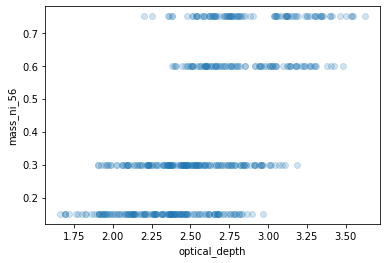

In [37]:
sns.regplot(x = "optical_depth", y="mass_ni_56", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [38]:
data1= supernovae_df['optical_depth']
data2= supernovae_df['mass_ni_56']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.627


There aren't any clear cut ranges for optical depth that can clearly be used to pinpoint the mass class, but they are significantly correlated

In [39]:
# Max-exp-vel vs ni-56 mass

<AxesSubplot:xlabel='max_exp_vel', ylabel='mass_ni_56'>

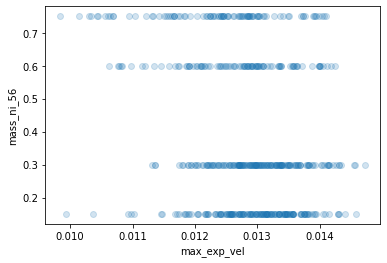

In [40]:
sns.regplot(x = "max_exp_vel", y="mass_ni_56", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [41]:
data1= supernovae_df['max_exp_vel']
data2= supernovae_df['mass_ni_56']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.261


## Total mass

In [42]:
# Emergent flux v/s total mass

<AxesSubplot:xlabel='emergent_flux', ylabel='total_mass'>

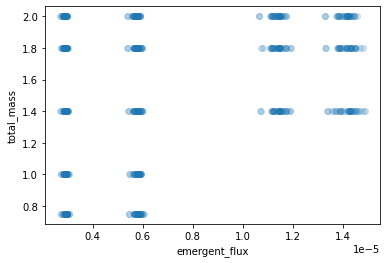

In [43]:
sns.regplot(x = "emergent_flux", y="total_mass", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [44]:
data1= supernovae_df['emergent_flux']
data2= supernovae_df['total_mass']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.357


In [45]:
# Optical depth v/s total mass

<AxesSubplot:xlabel='optical_depth', ylabel='total_mass'>

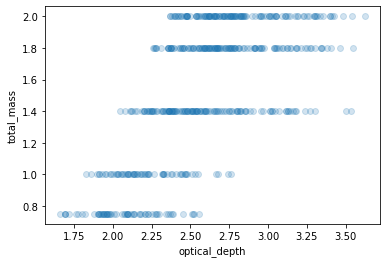

In [46]:
sns.regplot(x = "optical_depth", y="total_mass", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [47]:
data1= supernovae_df['optical_depth']
data2= supernovae_df['total_mass']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.663


In [48]:
#Max exp vel vs total mass

<AxesSubplot:xlabel='max_exp_vel', ylabel='total_mass'>

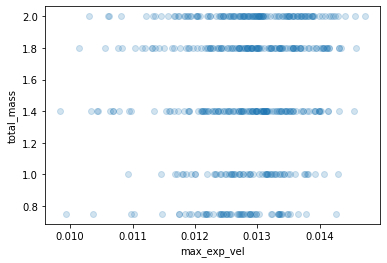

In [49]:
sns.regplot(x = "max_exp_vel", y="total_mass", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [50]:
data1= supernovae_df['max_exp_vel']
data2= supernovae_df['total_mass']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.102


In [51]:
supernovae_df['total_mass'].unique()

array([0.75, 1.  , 1.4 , 1.8 , 2.  ])

There are 5 classes of total mass so we can similarly create a categorical variable describing the mass class, as there are only 5 unique mass values. 

In [52]:
class_of_total = []
#5 classes of total_mass: <0.8, 0.8-1.2, 1.2-1.6, 1.6-1.9, >1.9
for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['total_mass']<=0.8:
        class_of_total.append(1)
    if supernovae_df.iloc[i]['total_mass']>0.8 and supernovae_df.iloc[i]['total_mass']<=1.2:
        class_of_total.append(2)
    if supernovae_df.iloc[i]['total_mass']>1.2 and supernovae_df.iloc[i]['total_mass']<=1.6:
        class_of_total.append(3)
    if supernovae_df.iloc[i]['total_mass']>1.6 and supernovae_df.iloc[i]['total_mass']<=1.9:
        class_of_total.append(4)
    if supernovae_df.iloc[i]['total_mass']>1.9:
        class_of_total.append(5)

In [53]:
supernovae_df['class_of_total_mass']=np.array(class_of_total)

## Explosion energy

In [54]:
#Emergent flux v/s explosion energy

<AxesSubplot:xlabel='emergent_flux', ylabel='explosion_energy'>

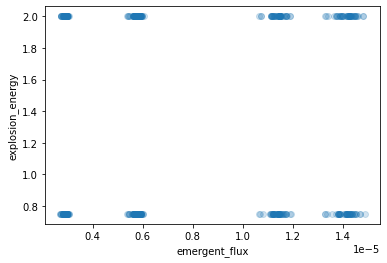

In [55]:
sns.regplot(x = "emergent_flux", y="explosion_energy", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [56]:
data1= supernovae_df['emergent_flux']
data2= supernovae_df['explosion_energy']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.001


In [57]:
#Optical depth v/s explosion energy

<AxesSubplot:xlabel='optical_depth', ylabel='explosion_energy'>

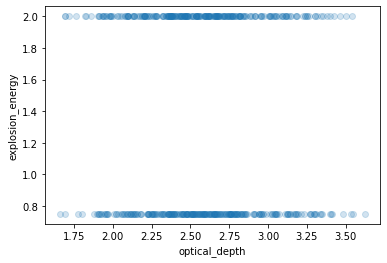

In [58]:
sns.regplot(x = "optical_depth", y="explosion_energy", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [59]:
data1= supernovae_df['optical_depth']
data2= supernovae_df['explosion_energy']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.033


In [60]:
#Max exp vel v/s explosion energy

<AxesSubplot:xlabel='max_exp_vel', ylabel='explosion_energy'>

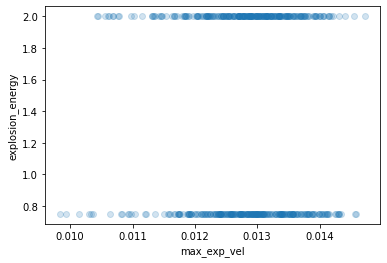

In [61]:
sns.regplot(x = "max_exp_vel", y="explosion_energy", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

In [62]:
data1= supernovae_df['optical_depth']
data2= supernovae_df['explosion_energy']

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.033


## Inital Mass distribution graphs

<AxesSubplot:xlabel='emergent_flux', ylabel='init_mass_dist'>

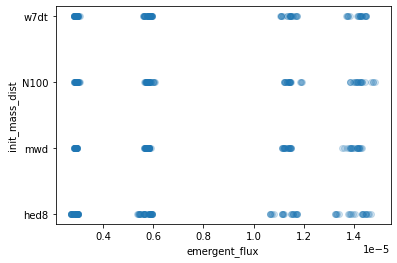

In [63]:
sns.regplot(x = "emergent_flux", y="init_mass_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='max_exp_vel', ylabel='init_mass_dist'>

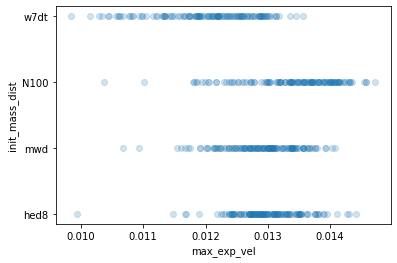

In [64]:
sns.regplot(x = "max_exp_vel", y="init_mass_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='optical_depth', ylabel='init_mass_dist'>

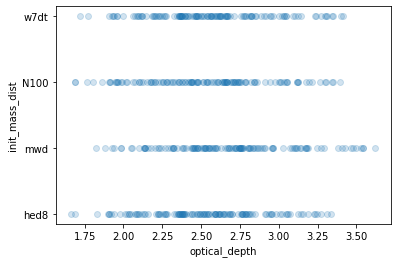

In [65]:
sns.regplot(x = "optical_depth", y="init_mass_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='class_of_flux', ylabel='init_mass_dist'>

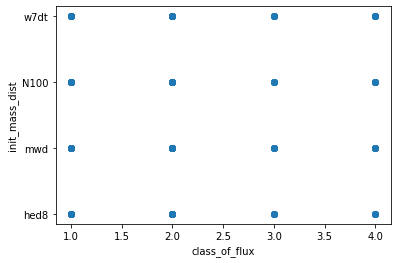

In [66]:
sns.regplot(x = "class_of_flux", y="init_mass_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

We can see that there are no clear-cut highly correlated relations, as all distributions of initial mass are found across classes of all other visible parameters

## Initial rad distribution graphs

<AxesSubplot:xlabel='emergent_flux', ylabel='init_rad_dist'>

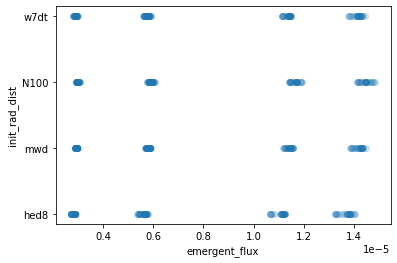

In [67]:
sns.regplot(x = "emergent_flux", y="init_rad_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='optical_depth', ylabel='init_rad_dist'>

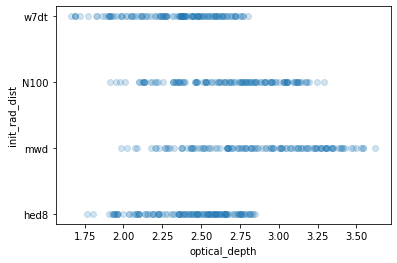

In [68]:
sns.regplot(x = "optical_depth", y="init_rad_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='max_exp_vel', ylabel='init_rad_dist'>

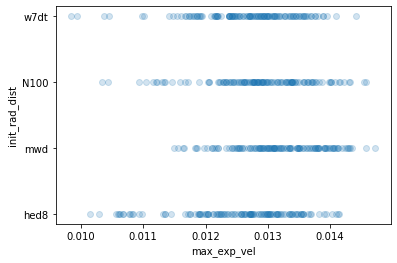

In [69]:
sns.regplot(x = "max_exp_vel", y="init_rad_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='class_of_flux', ylabel='init_rad_dist'>

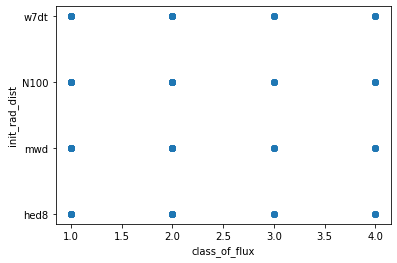

In [70]:
sns.regplot(x = "class_of_flux", y="init_rad_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

Similar to initial mass distribution, there are no clear-cut relations here

In [71]:
supernovae_df.iloc[0]

optical_depth              1.94063
optical_depth_unc         0.179354
max_exp_vel              0.0135306
max_exp_vel_unc        0.000669683
emergent_flux          2.72379e-06
total_mass                    0.75
mass_ni_56                    0.15
explosion_energy              0.75
init_mass_dist                hed8
init_rad_dist                 hed8
class_of_flux                    1
class_of_ni                      1
class_of_total_mass              1
Name: 0, dtype: object

## Plotting the physical parameters against each other

<AxesSubplot:xlabel='total_mass', ylabel='mass_ni_56'>

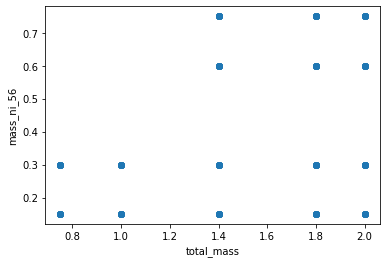

In [72]:
sns.regplot(x = "total_mass", y="mass_ni_56", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='total_mass', ylabel='explosion_energy'>

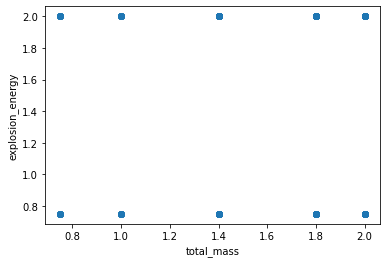

In [73]:
sns.regplot(x = "total_mass", y="explosion_energy", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='mass_ni_56', ylabel='explosion_energy'>

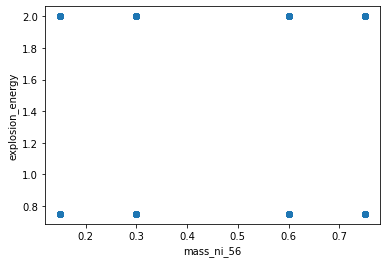

In [74]:
sns.regplot(x = "mass_ni_56", y="explosion_energy", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

We see here that explosion energy has 2 classes, which do not have unique values, but ranges. We can either directly predict explosion energy or predict explosion classes and take the average value. 

In [75]:
class_of_explosion=[]
#2 classes of explosion energy - <0.8, >1.9

for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['explosion_energy']<=0.8:
        class_of_explosion.append(1)
    if supernovae_df.iloc[i]['explosion_energy']>=1.9:
        class_of_explosion.append(2)

In [76]:
supernovae_df['class_of_explosion'] = np.array(class_of_explosion)

In [77]:
#PLOTTING THE newly created categorical class variables to find the relations

<AxesSubplot:xlabel='class_of_explosion', ylabel='class_of_total_mass'>

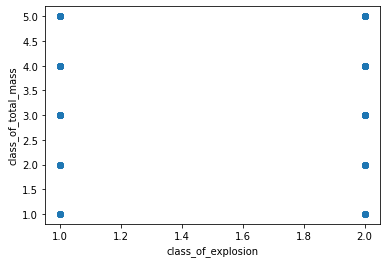

In [78]:
sns.regplot(x = "class_of_explosion", y="class_of_total_mass", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='class_of_ni', ylabel='class_of_total_mass'>

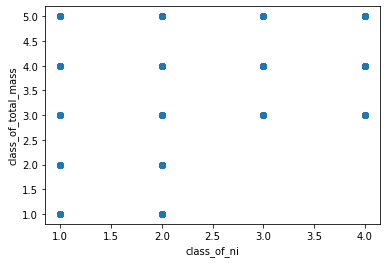

In [79]:
sns.regplot(x = "class_of_ni", y="class_of_total_mass", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='class_of_ni', ylabel='class_of_explosion'>

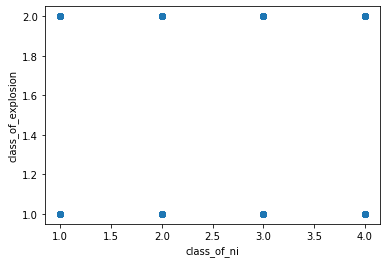

In [80]:
sns.regplot(x = "class_of_ni", y="class_of_explosion", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

<AxesSubplot:xlabel='init_mass_dist', ylabel='init_rad_dist'>

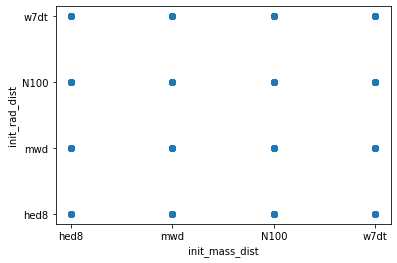

In [81]:
sns.regplot(x = "init_mass_dist", y="init_rad_dist", data=supernovae_df, fit_reg = False, scatter_kws={"alpha": 0.2})

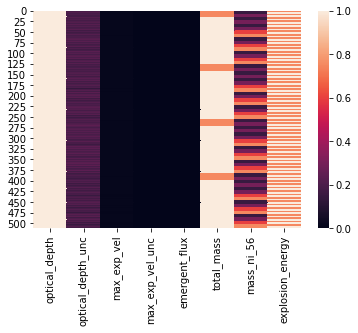

In [82]:
#HEATMAP PLOT
ax = sns.heatmap(supernovae_df[['optical_depth', 'optical_depth_unc', 'max_exp_vel',
       'max_exp_vel_unc', 'emergent_flux', 'total_mass', 'mass_ni_56',
       'explosion_energy']], vmin=0, vmax=1)

In [83]:
#Pearson correlation coefficients across the dataframe
supernovae_df.corr(method ='pearson')

,optical_depth,optical_depth_unc,max_exp_vel,max_exp_vel_unc,emergent_flux,total_mass,mass_ni_56,explosion_energy,class_of_flux,class_of_ni,class_of_total_mass,class_of_explosion
optical_depth,1.000000,0.419398,0.139121,-0.373153,0.632440,0.663398,6.267326e-01,-3.325508e-02,0.615870,0.615870,0.651897,-3.325508e-02
optical_depth_unc,0.419398,1.000000,0.574014,-0.001943,-0.205006,0.162289,-2.269546e-01,-1.577938e-02,-0.228639,-0.228639,0.164077,-1.577938e-02
max_exp_vel,0.139121,0.574014,1.000000,0.455342,-0.256229,0.101983,-2.611050e-01,-7.433199e-03,-0.250544,-0.250544,0.103835,-7.433199e-03
max_exp_vel_unc,-0.373153,-0.001943,0.455342,1.000000,-0.444985,-0.218342,-4.405073e-01,-8.135685e-02,-0.427781,-0.427781,-0.211990,-8.135685e-02
emergent_flux,0.632440,-0.205006,-0.256229,-0.444985,1.000000,0.356752,9.988396e-01,1.386505e-03,0.988591,0.988591,0.342323,1.386505e-03
total_mass,0.663398,0.162289,0.101983,-0.218342,0.356752,1.000000,3.617858e-01,0.000000e+00,0.339971,0.339971,0.992783,0.000000e+00
mass_ni_56,0.626733,-0.226955,-0.261105,-0.440507,0.998840,0.361786,1.000000e+00,7.529056e-19,0.989488,0.989488,0.347586,1.882264e-18
explosion_energy,-0.033255,-0.015779,-0.007433,-0.081357,0.001387,0.000000,7.529056e-19,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
class_of_flux,0.615870,-0.228639,-0.250544,-0.427781,0.988591,0.339971,9.894881e-01,0.000000e+00,1.000000,1.000000,0.326628,0.000000e+00
class_of_ni,0.615870,-0.228639,-0.250544,-0.427781,0.988591,0.339971,9.894881e-01,0.000000e+00,1.000000,1.000000,0.326628,0.000000e+00


We see here that most of the observable parameters are not highly correlated with the physical parameters. Hence, we would have to follow a step-by-step approach in order to successfully predict all the physical parameters with the given information. 

# Inference:
What we see here is that we can define classes for the numerical physical parameters. There isn't a lot of direct correlation between the parameters, except mass of ni-56 and emergent flux. The categorical targets (distribution columns) are evenly distributed across all other parameters and there is no strong correlation between any set of parameters and these target columns either. It is best to predict the target variables one after another, with the predictions of one variable being added as features to another variable. 

Recommended prediction order:
1. Ni-56 mass
2. Total mass
3. Initial mass distribution
4. Initial rad distribution
5. Explosion energy

Different models can be used for the same, only the best iterations have been mentioned here where possible.

# Task 3- PREDICTIONS

Trial-and-error to decide the best routine is then followed by the actual routine and predictions. 

# Predicting the Ni-56 mass

Predicting mass of Ni-56: two approaches (regression v/s classification). Classification is possible because the class of Ni-56 mass have unique values rather than ranges of values, so a properly predicted class can later be interpreted to the right value of the physical parameter. 


In [84]:
#LINEAR REGRESSION APPROACH

In [85]:
#Using only the observable parameters and regression to the actual mass

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux']]
y = supernovae_df['mass_ni_56'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test)) #R2 score

0.998169270629603


In [86]:
#Including the uncertainities 

In [87]:
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc']]
y = supernovae_df['mass_ni_56'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.9988249898838353


Since we know that the emergent flux and mass of ni-56 are highly correlated and our plots show that supernovae with the same range of emergent flux all have the same unique mass, it is possible to predict the class of ni and convert it to the actual value after.

In [88]:
#Using uncertainities, observable parameters, with target as the class of ni-56 mass

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc']]
y = supernovae_df['class_of_ni'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.9795483728077143


In [89]:
#Using only observable parameters
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux']]
y = supernovae_df['class_of_ni'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.9777909118034415


In [90]:
#Attempting single feature regression- using only emergent flux with direct regression

X = supernovae_df[['emergent_flux']]
y = supernovae_df['mass_ni_56'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.9981558603296407


In [91]:
#Attempting single feature regression- using only emergent flux with regression to classification

X = supernovae_df[['emergent_flux']]
y = supernovae_df['class_of_ni'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

0.9773500224702066


Using class of flux to predict class of ni-mass 

In [92]:
X = supernovae_df[['class_of_flux']]
y = supernovae_df['class_of_ni'] 
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LogisticRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test))

1.0


INFERENCE:
While the model accuracy is close to 100 using other parameters, this particular regression seems the best way forward as the variables are highly correlated and using a class based regression that gives 100% accuracy ensures high accuracy in the following steps

# Predicting total mass

As total mass is not highly linearly correlated with any other values, boosting based regression seemed to be the next best option. Here, different combinations of observable parameters as well as uncertainities are used as featuers, along with the mass of ni-56, which can easily be the first thing to be predicted because of the high accuracy achieved when training a model for the target of ni-56 mass.

In [93]:
#Regression to total mass using all possible variables 

X = supernovae_df[['optical_depth','max_exp_vel','optical_depth_unc','emergent_flux','mass_ni_56']]
y = supernovae_df['total_mass'] 
  
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


model.score(X_test, y_test)

0.7892008800736088

In [94]:
#All variables regression to mass class

X = supernovae_df[['optical_depth','max_exp_vel','optical_depth_unc','emergent_flux','mass_ni_56']]
y = supernovae_df['class_of_total_mass'] 
   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1220)

model = XGBClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

model.score(X_test, y_pred)

C:\Users\Aarya\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [95]:
#Classification using only observable parameters

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux']]
y = supernovae_df['class_of_total_mass'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

model.score(X_test, predictions)

[00:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [96]:
#Regression 

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','class_of_ni','optical_depth_unc']]
y = supernovae_df['total_mass'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1220)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

model.score(X_test, y_test)

0.7422190730485296

 INFERENCE:
 78.9% is a good accuracy, but getting an accuracy of 1 for the class of mass is good, because the class of mass directly correlates to unique mass values within the dataset, which could make the following predictions very accurate.XGBclassification would be better than the regression answers simply in terms of accuracy. 

As explosion energy is barely correlated with any of the other variables, it might be a good idea to keep it for the end once all other targets have been predicted

# Predicting initial mass distribution

In [97]:
#One Hot Encoding of initial mass dist

In [98]:
init_mass_dist =[]
for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['init_mass_dist']=='hed8':
        init_mass_dist.append(1)
    if supernovae_df.iloc[i]['init_mass_dist']=='mwd':
        init_mass_dist.append(2)
    if supernovae_df.iloc[i]['init_mass_dist']=='N100':
        init_mass_dist.append(3)
    if supernovae_df.iloc[i]['init_mass_dist']=='w7dt':
        init_mass_dist.append(4)

In [99]:
#One Hot Encoding of initial rad dist

In [100]:
rad_dist =[]
for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['init_rad_dist']=='hed8':
        rad_dist.append(1)
    if supernovae_df.iloc[i]['init_rad_dist']=='mwd':
        rad_dist.append(2)
    if supernovae_df.iloc[i]['init_rad_dist']=='N100':
        rad_dist.append(3)
    if supernovae_df.iloc[i]['init_rad_dist']=='w7dt':
        rad_dist.append(4)

In [101]:
#Adding these one-hot encodings to the dataframe

In [102]:
supernovae_df['mass_dist_encoding']=np.array(init_mass_dist)

In [103]:
supernovae_df['rad_dist_encoding']=np.array(rad_dist)

In [104]:
#XGBCLASSIFIER ON MASS DIST

In [105]:
#Using all currently know variables except max_exp_vel

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56','optical_depth_unc']]
y = supernovae_df['mass_dist_encoding'] 
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBClassifier()
model.fit(X_train, y_train)



[00:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Aarya\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
#XGBclassifier contd

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.47%


In [107]:
p1= np.array(predictions)
p2 = np.array((y_test))
dddf = pd.DataFrame({'y_test':p2, 'y_pred':p1})

In [108]:
dddf

,y_test,y_pred
0,2,2
1,4,4
2,1,1
3,1,1
4,4,4
...,...,...
98,4,4
99,2,2
100,3,3
101,3,3


In [109]:
#Removing the uncertainity values with classification

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56']]
y = supernovae_df['mass_dist_encoding'] 
  
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[00:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 76.70%


C:\Users\Aarya\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [110]:
#Including both uncertainities

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56','optical_depth_unc','max_exp_vel_unc']]
y = supernovae_df['mass_dist_encoding'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[00:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 77.67%


INFERENCE:
The best accuracy obtained was 84.47% using the XGBclassifier and all currently known features (as per the prediction order) except for the max_exp_vel_unc, so this method can be used. 

# Predicting initial rad distribution

In [111]:
#INIT RAD DIST

In [112]:
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56','mass_dist_encoding', 'optical_depth_unc']]
y = supernovae_df['rad_dist_encoding'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[00:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 93.20%


In [113]:
p1= np.array(predictions)
p2 = np.array((y_test))
dddf = pd.DataFrame({'y_test':p2, 'y_pred':p1})

In [114]:
dddf

,y_test,y_pred
0,1,1
1,3,3
2,2,2
3,4,4
4,4,4
...,...,...
98,2,2
99,4,4
100,2,2
101,1,1


INFERENCE:
As this classifier provided a 93% accuracy with the given set of hyperparameters, this can be satisfactorily used for the prediction pipelines.

# Predicting explosion energy

As explosion energy is numerical and has 2 ranges as classes instead of 2 unique values for classes, 2 approaches can be followed to predict explosion energy. The first one is regression to find the exact explosion energy, which is preferable as the classification method would substitute the predicted class with the average value of explosion energy for that class rather than some unique value, therefore making the classification route more inaccurate. 

However, explosion energy has no correlation with most of the known features at this point, so both approaches can be tried and then compared. 

REGRESSION APPROACH

In [115]:
#Linear regression

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['explosion_energy']  
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test)) #R2 score

-0.033193118819107914


In [116]:
#XG boost regression

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['explosion_energy'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


model.score(X_test, y_test)

-0.7158443840894702

In [117]:
p1= np.array(y_pred)
p2 = np.array((y_test))
dddf = pd.DataFrame({'y_test':p2, 'y_pred':p1})

In [118]:
dddf

,y_test,y_pred
0,2.00,1.468828
1,2.00,1.013036
2,0.75,1.718580
3,2.00,1.641631
4,0.75,0.905168
...,...,...
98,0.75,1.437048
99,0.75,0.831649
100,2.00,1.529058
101,0.75,0.776261


In [119]:
#Decision tree regression

from sklearn.tree import DecisionTreeRegressor 
  
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['explosion_energy'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)
regressor = DecisionTreeRegressor(random_state = 0) 
  

regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [120]:
regressor.score(X_test, y_test)

-1.3409090909090904

In [121]:
#Random forest regression

from sklearn.ensemble import RandomForestRegressor 
  
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['explosion_energy'] 

regressor = RandomForestRegressor(n_estimators = 100, random_state = 75)

regressor.fit(X_train,y_train)

RandomForestRegressor(random_state=75)

In [122]:
regressor.score(X_test,y_test)

-0.4020523863636358

In [123]:
#Random forest regression with a different random state

from sklearn.ensemble import RandomForestRegressor 
  
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['explosion_energy'] 

regressor = RandomForestRegressor(n_estimators = 100, random_state = 1220)

regressor.fit(X_train,y_train)
regressor.score(X_test,y_test)

-0.39880242424242374

In [124]:
#ANN

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','mass_ni_56', 'total_mass','mass_dist_encoding','rad_dist_encoding']]
y = supernovae_df[['explosion_energy']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=75)
 
model = Sequential()
model.add(Dense(20, input_dim=7, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(14, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                294       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 120       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.fit(X_train,y_train,batch_size=32,epochs=500, validation_data=(X_test,y_test))

Epoch 1/500
12/12 [==============================] - 1s 72ms/step - loss: 0.8687 - val_loss: 0.7735
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.7335 - val_loss: 0.6669
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6679 - val_loss: 0.6159
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6568 - val_loss: 0.6144
Epoch 5/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6339 - val_loss: 0.6141
Epoch 6/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6189 - val_loss: 0.6142
Epoch 7/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6024 - val_loss: 0.6142
Epoch 8/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6418 - val_loss: 0.6142
Epoch 9/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6228 - val_loss: 0.6143
Epoch 10/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6547 - val_loss: 0.6144
Epoch 11

CLASSIFICATION APPROACH

In [126]:
#KNN classifier

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','optical_depth_unc','max_exp_vel_unc','rad_dist_encoding','mass_dist_encoding']]
y = supernovae_df['class_of_explosion'] 
  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=75)


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=66)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[22 44]
 [18 44]]
              precision    recall  f1-score   support

           1       0.55      0.33      0.42        66
           2       0.50      0.71      0.59        62

    accuracy                           0.52       128
   macro avg       0.53      0.52      0.50       128
weighted avg       0.53      0.52      0.50       128



In [127]:
#Logistic regression

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux', 'mass_ni_56','total_mass','mass_dist_encoding','rad_dist_encoding']]
y = supernovae_df['class_of_explosion'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)



model = LogisticRegression(solver='liblinear', random_state=0)

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.4563106796116505

In [128]:
#Kmeans clustering

from sklearn.cluster import KMeans
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux', 'mass_ni_56','total_mass','mass_dist_encoding','rad_dist_encoding']]
y = supernovae_df['class_of_explosion']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=7, random_state=75)
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init=7, random_state=75)

In [129]:
y_pred = kmeans.predict(X_test)

In [130]:
y_pred+=1

In [131]:
p1= np.array(y_pred)
p2 = np.array((y_test))
dddf = pd.DataFrame({'y_test':p2, 'y_pred':p1})

In [132]:
dddf

,y_test,y_pred
0,2,2
1,2,1
2,1,2
3,2,2
4,1,1
...,...,...
98,1,1
99,1,2
100,2,1
101,1,1


In [133]:
#ACCURACY OF KMEANS CLUSTERING
acc = 0
for i in range(len(dddf)):
    if dddf.iloc[i]['y_test']==dddf.iloc[i]['y_pred']:
        acc+=1
    
print('K means clustering accuracy: ',acc/len(dddf))

K means clustering accuracy:  0.5145631067961165


In [134]:
#Decision tree classifier using gini index and entropy both as criterion

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux', 'mass_ni_56','total_mass','mass_dist_encoding','rad_dist_encoding']]
y = supernovae_df['class_of_explosion']  
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=75)
      
    

In [135]:
    
d_tree_gini= DecisionTreeClassifier(criterion = "gini", random_state = 121,max_depth=3, min_samples_leaf=5)
  
d_tree_gini.fit(X_train, y_train) 
    
dtree_entropy= DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 3, min_samples_leaf = 5)
  
dtree_entropy.fit(X_train, y_train)
  
  
  

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=100)

In [136]:

y_gini_pred = d_tree_gini.predict(X_test)
y_eb_pred = dtree_entropy.predict(X_test)
      

      

In [137]:
accuracy_score(y_test, y_gini_pred)

0.5242718446601942

In [138]:
accuracy_score(y_test, y_eb_pred)

0.5242718446601942

In [139]:
#Using a CNN classifier

In [140]:
X1 = supernovae_df[['optical_depth','max_exp_vel','emergent_flux', 'mass_ni_56','total_mass','mass_dist_encoding','rad_dist_encoding']]
y1 = supernovae_df['class_of_explosion']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=175)

In [141]:
X1_train =np.expand_dims(X_train, axis=2)
X1_test= np.expand_dims(X_test, axis=2)

In [142]:
model = Sequential()

model.add(Conv1D(16, 7, kernel_initializer='normal',padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(12, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(12, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Conv1D(10, 5,padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('softmax'))


In [143]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [144]:
cnntrain=model.fit(X1_train, y1_train, batch_size=48, epochs=500, validation_data=(X1_test, y1_test))

Epoch 1/500
9/9 [==============================] - 1s 29ms/step - loss: 0.0000e+00 - accuracy: 0.5048 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 2/500
9/9 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5020 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 3/500
9/9 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.4828 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 4/500
9/9 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.4979 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 5/500
9/9 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4977 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 6/500
9/9 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4682 - val_loss: 0.0000e+00 - val_accuracy: 0.5146
Epoch 7/500
9/9 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5086 - val_loss: 0.00

INFERENCE:

The best method for predicting explosion energy seems to be classification using gini index followed by assigning the average value of the class to the new supernova.

# Compiling the final models together in steps

## Linear regression for ni-56

In [145]:
X = supernovae_df[['class_of_flux']]
y = supernovae_df['class_of_ni'] 

ni56 = LogisticRegression() 
  
ni56.fit(X,y) 


LogisticRegression()

## XGBclassification for total mass class

In [146]:
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux']]
y = supernovae_df['class_of_total_mass'] 


totalmass = XGBClassifier()
totalmass.fit(X,y)



[00:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Aarya\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## xgbclassifier for init mass dist

In [147]:
#Using all currently know variables except max_exp_vel

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56','optical_depth_unc']]
y = supernovae_df['mass_dist_encoding'] 


initmassdist = XGBClassifier()
initmassdist.fit(X,y)


[00:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Init rad dist  xgb classifier

In [148]:
X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux','total_mass','mass_ni_56','mass_dist_encoding', 'optical_depth_unc']]
y = supernovae_df['rad_dist_encoding'] 


initraddist = XGBClassifier()
initraddist.fit(X,y)


[00:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Explosion class

In [149]:

X = supernovae_df[['optical_depth','max_exp_vel','emergent_flux', 'mass_ni_56','total_mass','mass_dist_encoding','rad_dist_encoding']]
y = supernovae_df['class_of_explosion']

    
explosionclassgini= DecisionTreeClassifier(criterion = "gini", random_state = 121,max_depth=3, min_samples_leaf=5)
  
explosionclassgini.fit(X,y) 

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=121)

# Routine:

pre-processing: find the uncertainities
1. predict ni-56 mass
2. predict total mass class, and convert to total mass 
3. predict distributions
4. predict explosion class and assign average value

In [150]:
print('Average OD uncertainity ratio', mean_od_unc_per)
print('Average MEV uncertainity ratio', mean_mev_unc_per)

Average OD uncertainity ratio 0.078545
Average MEV uncertainity ratio 0.039927


In [151]:
supernovae_df['mass_ni_56'].unique()

array([0.15, 0.3 , 0.6 , 0.75])

In [152]:
supernovae_df['total_mass'].unique()

array([0.75, 1.  , 1.4 , 1.8 , 2.  ])

In [153]:
sumeclass1 = 0
noeclass1 = 0
sumeclass2 = 0
noeclass2 = 0

for i in range(len(supernovae_df)):
    if supernovae_df.iloc[i]['class_of_explosion']==1:
        noeclass1+=1
        sumeclass1+=supernovae_df.iloc[i]['explosion_energy']
    else:
        noeclass2+=1
        sumeclass2+=supernovae_df.iloc[i]['explosion_energy']
        
        
eclass1avg = sumeclass1/noeclass1
eclass2avg = sumeclass2/noeclass2

In [154]:
eclass1avg

0.75

In [155]:
eclass2avg

2.0

In [156]:
def assign_flux_class(efluxparam):
    if efluxparam<0.000004:
        return 1
    if  efluxparam<0.000008 and efluxparam>0.000004:
        return 2
    if  efluxparam <0.000013 and efluxparam>0.000010:
        return 3
    if efluxparam >0.000013:
        return 4
    
    
def get_ni_56_mass(ni_56):
    if ni_56 == 1:
        return 0.15
    if ni_56==2:
        return 0.3
    if ni_56 == 3:
        return 0.6
    if ni_56 == 4:
        return 0.75

def return_total_mass(totalmassclass):
    if totalmassclass == 1:
        return 0.75
    if totalmassclass ==2:
        return 1
    if totalmassclass ==3:
        return 1.4
    if totalmassclass ==4:
        return 1.8
    if totalmassclass ==5:
        return 2


def return_dist_class_to_str(distclass):
    if distclass == 1:
        return 'hed8'
    if distclass == 2:
        return 'mwd'
    if distclass == 3:
        return 'N100'
    if distclass ==4:
        return 'w7dt'

def return_avg_explosion_eng(eclassflag):
    if eclassflag == 1:
        return eclass1avg
    else:
        return eclass2avg

def supernovae_routine(odparam, mevparam, efluxparam):
    od_unc = mean_od_unc_per * odparam
    mev_unc = mean_mev_unc_per * mevparam
    
    efluxclass = assign_flux_class(efluxparam)
    
    efluxclasslist =[]
    efluxclasslist.append(efluxclass)
    efluxclasslistnp = np.array(efluxclasslist)
    efluxclassdf = pd.DataFrame(efluxclasslistnp)
    ni_56 = ni56.predict(efluxclassdf)
    nimass = get_ni_56_mass(ni_56)
    
    tmdata = {'optical_depth':[odparam], 'max_exp_vel':[mevparam], 'emergent_flux':[efluxparam]}
    tmdf = pd.DataFrame(tmdata)
    totalmassclass_val = totalmass.predict(tmdf)
    totalmass_val = return_total_mass(totalmassclass_val)
    
    massdistdata = {'optical_depth':[odparam], 'max_exp_vel':[mevparam], 'emergent_flux':[efluxparam], 'total_mass':[totalmass_val],'mass_ni_56':[nimass],'optical_depth_unc':[od_unc]}
    massdistdf = pd.DataFrame(massdistdata)
    massdistflag = initmassdist.predict(massdistdf)
    print(type(massdistflag[0]))
    initmassdist_str = return_dist_class_to_str(massdistflag)
    
    raddistdata = {'optical_depth':[odparam], 'max_exp_vel':[mevparam], 'emergent_flux':[efluxparam], 'total_mass':[totalmass_val], 'mass_ni_56':[nimass], 'mass_dist_encoding':[massdistflag[0]],'optical_depth_unc':[od_unc]}
    raddistdf = pd.DataFrame(raddistdata)
    raddistflag = initraddist.predict(raddistdf)
    initraddist_str = return_dist_class_to_str(raddistflag)
    
    expldata = {'optical_depth':[odparam], 'max_exp_vel':[mevparam], 'emergent_flux':[efluxparam], 'mass_ni_56':[nimass], 'total_mass':[totalmass_val],  'mass_dist_encoding':[massdistflag[0]], 'rad_dist_encoding':[raddistflag[0]]}
    expldf = pd.DataFrame(expldata)
    eclassflag = explosionclassgini.predict(expldf)
    explosion_energy_val = return_avg_explosion_eng(eclassflag)
    
    result = []
    result.append(nimass)
    result.append(totalmass_val)
    result.append(explosion_energy_val)
    result.append(initmassdist_str)
    result.append(initraddist_str)
    
    return result

In [157]:
#Example 

In [158]:
supernovae_df.iloc[0]

optical_depth              1.94063
optical_depth_unc         0.179354
max_exp_vel              0.0135306
max_exp_vel_unc        0.000669683
emergent_flux          2.72379e-06
total_mass                    0.75
mass_ni_56                    0.15
explosion_energy              0.75
init_mass_dist                hed8
init_rad_dist                 hed8
class_of_flux                    1
class_of_ni                      1
class_of_total_mass              1
class_of_explosion               1
mass_dist_encoding               1
rad_dist_encoding                1
Name: 0, dtype: object

In [159]:
supernovae_routine(1.94063, 0.0135306,.00000272379)

<class 'numpy.int32'>


[0.15, 0.75, 2.0, 'hed8', 'hed8']

# Test case 1:
1. od= 3.35
2. mev = 0.015
3. eflux = 1.20×10-5

In [160]:
supernovae_routine(3.35, 0.015,.0000120)

<class 'numpy.int32'>


[0.6, 1.8, 2.0, 'N100', 'mwd']

# Test case 2:

1. od = 2.54
2. mev = 0.013
3. eflux = 5.02×10-6

In [161]:
supernovae_routine(2.54, 0.013,.00000502)

<class 'numpy.int32'>


[0.3, 2, 2.0, 'hed8', 'w7dt']

# Test case 3:

1. od = 2.46
2. mev = 0.013
3. eflux = 1.03×10-5

In [162]:
supernovae_routine(2.46, 0.013,.0000103)

<class 'numpy.int32'>


[0.6, 1.4, 2.0, 'hed8', 'w7dt']

# Conclusion:

The current routine can be used as a pipeline to predict physical parameters of supernovae. For the cases of mass ni-56 and total mass, the regression methods can also be adopted as those provide sufficiently good accuracy (0.99 R2 score with linear regression and 78.9% accuracy with XGBoost regressor respectively). 



